Hello! This is my Jupyter Notebook showing my dataset, exploration of the dataset 
and training of the ridge regression model that will later be used on my web application.

The dataset used for this project contains features of different cars and
the price of those cars.

I will attempt to use a ridge regression model to make predictions about the price
of cars using features of the dataset.

Right off the bat lets just import everything we'll need

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score

Now lets bring in the dataset

In [67]:
cols = ["symboling","normalized-losses","make","fuel-type","aspiration",
        "num-of-doors","body-style","drive-wheels","engine-location",
        "wheel-base","length","width","height","curb-weight","engine-type",
        "num-of-cylinders","engine-size","fuel-system","bore","stroke",
        "compression-ratio","horsepower","peak-rpm","city-mpg","highway-mpg",
        "price"]

df = pd.read_csv("data/raw/imports-85.data", names=cols, na_values="?", header=None)
df.head()


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


Now lets get the datatypes of each numeric column of the dataset.

In [69]:
numeric_cols = [
    "symboling", "normalized-losses", "wheel-base", "length", "width", "height",
    "curb-weight", "engine-size", "bore", "stroke", "compression-ratio",
    "horsepower", "peak-rpm", "city-mpg", "highway-mpg", "price"
]

for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

df[numeric_cols].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  164 non-null    float64
 2   wheel-base         205 non-null    float64
 3   length             205 non-null    float64
 4   width              205 non-null    float64
 5   height             205 non-null    float64
 6   curb-weight        205 non-null    int64  
 7   engine-size        205 non-null    int64  
 8   bore               201 non-null    float64
 9   stroke             201 non-null    float64
 10  compression-ratio  205 non-null    float64
 11  horsepower         203 non-null    float64
 12  peak-rpm           203 non-null    float64
 13  city-mpg           205 non-null    int64  
 14  highway-mpg        205 non-null    int64  
 15  price              201 non-null    float64
dtypes: float64(11), int64(5)
m

Now lets get the correlation of the numeric columns to the price.

This will give us the r value of each numeric column
the higher the r value should result in a higher price
a low negative value should result in a lower price

In [70]:
corr = df[numeric_cols].corr(numeric_only=True)["price"].sort_values(ascending=False)
corr


price                1.000000
engine-size          0.872335
curb-weight          0.834415
horsepower           0.810533
width                0.751265
length               0.690628
wheel-base           0.584642
bore                 0.543436
normalized-losses    0.203254
height               0.135486
stroke               0.082310
compression-ratio    0.071107
symboling           -0.082391
peak-rpm            -0.101649
city-mpg            -0.686571
highway-mpg         -0.704692
Name: price, dtype: float64

To get a visual of these r values we'll make a heatmap showing the r values of the different
numberic features

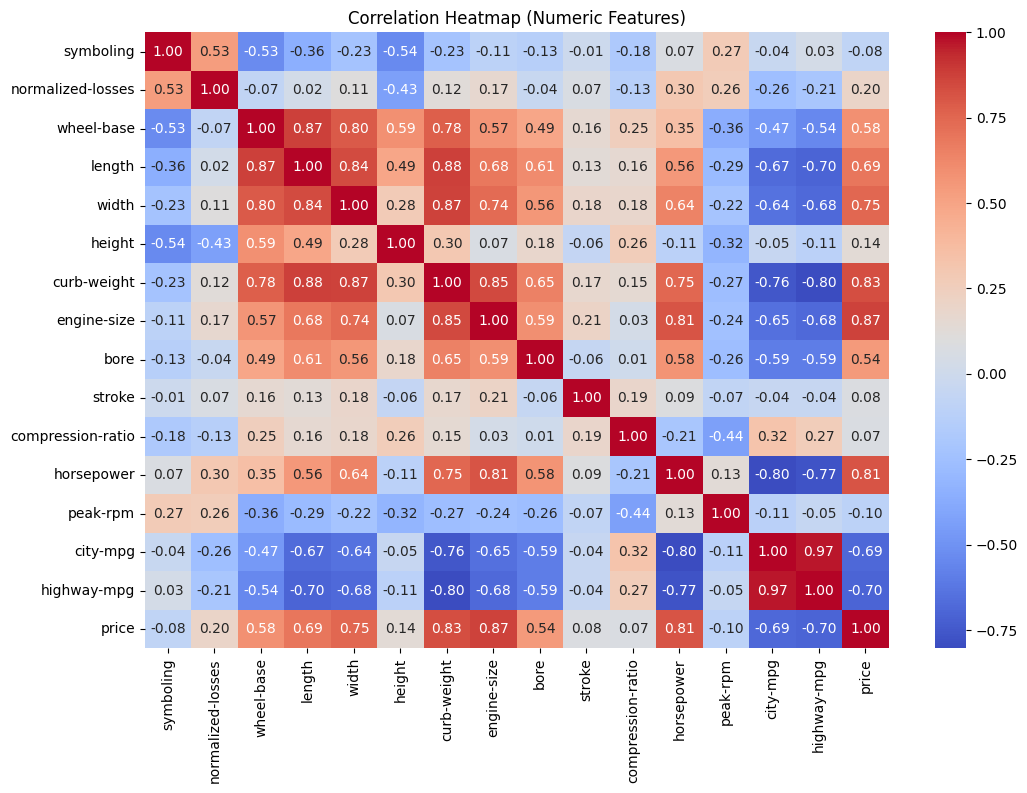

In [71]:
plt.figure(figsize=(12,8))
sns.heatmap(df[numeric_cols].corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


We are only going to keep numeric features that either have a high r value or
a low negative r value. These should be the key predictors of the model.

In [72]:

important_features = [
    "wheel-base", "length", "width", "curb-weight", "engine-size",
    "horsepower", "city-mpg", "highway-mpg"
]


categorical_features = [
    "make", "fuel-type", "aspiration", "num-of-doors",
    "body-style", "drive-wheels", "engine-location", "engine-type",
    "num-of-cylinders", "fuel-system"
]

selected_features = important_features + categorical_features

df_reduced = df[selected_features + ["price"]].copy()
df_reduced.head()



,wheel-base,length,width,curb-weight,engine-size,horsepower,city-mpg,highway-mpg,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,engine-type,num-of-cylinders,fuel-system,price
0,88.6,168.8,64.1,2548,130,111.0,21,27,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi,13495.0
1,88.6,168.8,64.1,2548,130,111.0,21,27,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi,16500.0
2,94.5,171.2,65.5,2823,152,154.0,19,26,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,16500.0
3,99.8,176.6,66.2,2337,109,102.0,24,30,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi,13950.0
4,99.4,176.6,66.4,2824,136,115.0,18,22,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi,17450.0


Now before we can start creating the model were going to clean the dataset of missing values

Here we are going to check which features contain missing values and how many values are missing

In [73]:
df_reduced.isna().sum().sort_values(ascending=False)

price               4
horsepower          2
num-of-doors        2
width               0
length              0
wheel-base          0
curb-weight         0
highway-mpg         0
make                0
engine-size         0
city-mpg            0
aspiration          0
fuel-type           0
drive-wheels        0
body-style          0
engine-location     0
engine-type         0
num-of-cylinders    0
fuel-system         0
dtype: int64

We have a low number of records containing missing values so were just going to drop those

In [74]:
df_clean = df_reduced.dropna().copy()

print(f"Removed {len(df_reduced) - len(df_clean)} rows; remaining: {len(df_clean)}")

df_clean.isna().sum().any()

Removed 8 rows; remaining: 197


np.False_

Check to make sure we don't have any missing values

In [75]:
df_clean.isna().sum().sort_values(ascending=False)

wheel-base          0
length              0
width               0
curb-weight         0
engine-size         0
horsepower          0
city-mpg            0
highway-mpg         0
make                0
fuel-type           0
aspiration          0
num-of-doors        0
body-style          0
drive-wheels        0
engine-location     0
engine-type         0
num-of-cylinders    0
fuel-system         0
price               0
dtype: int64

Alright, we now have a dataset with no missing values
We're in a good position to start training
First lets create the training and test sets

In [ ]:
# Separate features (X) and target (y)
X = df_clean.drop(columns=["price"])
y = df_clean["price"].astype(float)

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=67
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Ok now were going to split the features in the training set to numeric and catagorical
We're doing this so we can scale and encode them properly

In [ ]:
# Column splits
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

We'll apply a scale to the numeric values so the ridge regression treats them all fairly

What we'll have for the numeric values after this scaling is how many standard deviations away from
the average each value is. This is help the model treat each feature fairly

This will be used later in the preprocess step

In [ ]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

We'll now set up encoding the catagorical data

Example: fuel type will wither be gas or diesel if the record has gas as the fuel type
gas will get a value of 1. This will later be multiplied by a coeffient that will then be added to
the predicted price

This will be used later in the preprocess step

In [ ]:
categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

Now we have the complete preprocessing step that will scale and encode

In [ ]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ]
)

Alot is being set up here

pipe is going to be used in the cv training 

pipe is going to apply the scaling and transformation to the features and then will apply the ridge regression
to the training set 

The learned preprocessing on the training data will be used on the test dataset to make predictions

In [ ]:
ridge = Ridge(random_state=RANDOM_STATE)

pipe = Pipeline(steps=[
    ("preprocess", preprocess),
    ("model", ridge),
])

Alright now we search for the alpha hyper parameter of the ridge regression.

alot here

We set up the parameter grid to test 13 different alpha values

alpha values are used in ridge regression to lower the weight given to correlated features to get a bias / variance balance. A higher alpha will result in higher penalties (more bias) while a low alpha will have less smoothing of correlated features (more variance).

We do a 5 fold cross validation on each alpha value (65 total fittings). Each cv will train on 4 of the folds and validate on the 5th, this will happen until each fold has had a turn as the validation fold.

For each alpha validation (13 total) we get the average rmse of the 5 folds this will be the average RMSE of that alpha value.

We will the compare those average RMSEs to get the best alpha value for the model.

search.fit will get us the final trained model that will be used next on the test dataset


In [87]:
param_grid = {"model__alpha": np.logspace(-3, 3, 13)}
search = GridSearchCV(
    pipe, param_grid=param_grid, cv=5,
    scoring="neg_root_mean_squared_error", n_jobs=-1
)

search.fit(X_train, y_train)

print("Best alpha:", search.best_params_["model__alpha"])
print("Best CV RMSE:", -search.best_score_)


Best alpha: 0.31622776601683794
Best CV RMSE: 2408.9372759875137


OK we now have the best alpha and best model!

We'll use this model on the training dataset to calc rmse and r^2 training
Then we do this on the test dataset to calc rmse and r^2 testing

We now have a fully trained model that will need to be pickled and used in the web application

In [86]:
best_model = search.best_estimator_

y_pred_train = best_model.predict(X_train)
y_pred_test  = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_pred_train)
rmse_train = np.sqrt(mse_train)
r2_train   = r2_score(y_train, y_pred_train)

mse_test  = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)              
r2_test   = r2_score(y_test, y_pred_test)

print(f"Train RMSE: {rmse_train:.2f} | R²: {r2_train:.3f}")
print(f" Test RMSE: {rmse_test:.2f} | R²: {r2_test:.3f}")

Train RMSE: 1417.22 | R²: 0.967
 Test RMSE: 2679.00 | R²: 0.907
